# Homework 9 - Descriptive Notebook

In this homework notebook, we will create and train our own SkipGram embedding, by using the speech from Martin Luther King in the text.text file.

Get familiar with the code and write a small report (2 pages max), with answers to the questions listed at the end of the notebook.

**The report must be submitted in PDF format, before April 4th, 11.59pm!**

Do not forget to write your name and student ID on the report.

You may also submit your own copy of the notebook along with the report. If you do so, please add your name and ID to the cell below.

**Name: Loh De Rong**

**Student ID: 1003557**

### Imports needed

Note, we strongly advise to use a CUDA/GPU machine for this notebook.

Technically, this can be done on CPU only, but it will be very slow!

If you decide to use it on CPU, you might also have to change some of the .cuda() methods used on torch tensors and models in this notebook!

In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import functools
import matplotlib.pyplot as plt
CUDA = torch.cuda.is_available()

### Step 1. Produce some data based on a given text for training our SkipGram model    

The functions below will be used to produce our dataset for training the SkipGram model.

In [2]:
def text_to_train(text, context_window):
    """
    This function receives the text as a list of words, in lowercase format.
    It then returns data, a list of all the possible (x,y) pairs with
    - x being the middle word of the sentence of length 2*context_window+1,
    - y being a list of 2k words, containing the k preceding words and the k
    posterior words.
    """
    
    # Get data from list of words in text, using a context window of size k = context_window
    data = []
    for i in range(context_window, len(text) - context_window):
        target = [text[i+e] for e in range(-context_window, context_window+1) if i+e != i]
        input_word = text[i]
        data.append((input_word, target))
        
    return data

In [3]:
def create_text():
    """
    This function loads the string of text from the text.txt file,
    and produces a list of words in string format, as variable text.
    """
    
    # Load corpus from file
    with open("./text.txt", 'r', encoding="utf8",) as f:
        corpus = f.readlines()
    f.close()
    
    # Join corpus into a single string
    text = ""
    for s in corpus:
        l = s.split()
        for s2 in l:
            # Removes all special characters from string
            s2 = ''.join(filter(str.isalnum, s2))
            s2 += ' '
            text += s2.lower()
    text = text.split()
    
    return text

In [4]:
text = create_text()
print(text)

['i', 'am', 'happy', 'to', 'join', 'with', 'you', 'today', 'in', 'what', 'will', 'go', 'down', 'in', 'history', 'as', 'the', 'greatest', 'demonstration', 'for', 'freedom', 'in', 'the', 'history', 'of', 'our', 'nation', 'five', 'score', 'years', 'ago', 'a', 'great', 'american', 'in', 'whose', 'symbolic', 'shadow', 'we', 'stand', 'today', 'signed', 'the', 'emancipation', 'proclamation', 'this', 'momentous', 'decree', 'came', 'as', 'a', 'great', 'beacon', 'of', 'hope', 'to', 'millions', 'of', 'slaves', 'who', 'had', 'been', 'seared', 'in', 'the', 'flames', 'of', 'whithering', 'injustice', 'it', 'came', 'as', 'a', 'joyous', 'daybreak', 'to', 'end', 'the', 'long', 'night', 'of', 'their', 'captivity', 'but', 'one', 'hundred', 'years', 'later', 'the', 'colored', 'america', 'is', 'still', 'not', 'free', 'one', 'hundred', 'years', 'later', 'the', 'life', 'of', 'the', 'colored', 'american', 'is', 'still', 'sadly', 'crippled', 'by', 'the', 'manacle', 'of', 'segregation', 'and', 'the', 'chains', '

In [5]:
def generate_data(text, context_window):
    """
    This function receives the text and context window size.
    It produces four outputs:
    - vocab, a set containing the words found in text.txt,
    without any doublons,
    - word2index, a dictionary to convert words to their integer index,
    - word2index, a dictionary to convert integer index to their respective words,
    - data, containing our (x,y) pairs for training.
    """
    
    # Create vocabulary set V
    vocab = set(text)
    
    # Word to index and index 2 word converters
    word2index = {w:i for i,w in enumerate(vocab)}
    index2word = {i:w for i,w in enumerate(vocab)}
    
    # Generate data
    data = text_to_train(text, context_window)
    
    return vocab, data, word2index, index2word

In [6]:
vocab, data, word2index, index2word = generate_data(text, context_window = 2)

In [7]:
print(vocab)

{'white', 'time', 'insufficient', 'must', 'created', 'rolls', 'lips', 'midst', 'never', 'hold', 'able', 'solid', 'as', 'oasis', 'riches', 'robbed', 'engage', 'dignity', 'sense', 'citizen', 'selfevident', 'died', 'bank', 'blow', 'own', 'new', 'nor', 'yes', 'this', 'proclamation', 'curvaceous', 'independence', 'we', 'is', 'bankrupt', 'awakening', 'symbolic', 'happiness', 'country', 'snowcapped', 'governor', 'slums', 'heavy', 'for', 'tis', 'come', 'or', 'fatigue', 'alabama', 'pilgrims', 'little', 'having', 'joyous', 'only', 'racists', 'your', 'hampshire', 'signing', 'rough', 'former', 'ago', 'lonely', 'its', 'quest', 'judged', 'millions', 'pass', 'what', 'when', 'reality', 'would', 'history', 'hotels', 'jews', 'left', 'suffering', 'cooling', 'ghetto', 'see', 'climb', 'go', 'finds', 'whirlwinds', 'signs', 'usual', 'manacle', 'storms', 'foundations', 'vaults', 'concerned', 'rooted', 'wrote', 'children', 'straight', 'republic', 'difficulties', 'knowing', 'dripping', 'material', 'sons', 'slav

In [8]:
print(word2index)

{'white': 0, 'time': 1, 'insufficient': 2, 'must': 3, 'created': 4, 'rolls': 5, 'lips': 6, 'midst': 7, 'never': 8, 'hold': 9, 'able': 10, 'solid': 11, 'as': 12, 'oasis': 13, 'riches': 14, 'robbed': 15, 'engage': 16, 'dignity': 17, 'sense': 18, 'citizen': 19, 'selfevident': 20, 'died': 21, 'bank': 22, 'blow': 23, 'own': 24, 'new': 25, 'nor': 26, 'yes': 27, 'this': 28, 'proclamation': 29, 'curvaceous': 30, 'independence': 31, 'we': 32, 'is': 33, 'bankrupt': 34, 'awakening': 35, 'symbolic': 36, 'happiness': 37, 'country': 38, 'snowcapped': 39, 'governor': 40, 'slums': 41, 'heavy': 42, 'for': 43, 'tis': 44, 'come': 45, 'or': 46, 'fatigue': 47, 'alabama': 48, 'pilgrims': 49, 'little': 50, 'having': 51, 'joyous': 52, 'only': 53, 'racists': 54, 'your': 55, 'hampshire': 56, 'signing': 57, 'rough': 58, 'former': 59, 'ago': 60, 'lonely': 61, 'its': 62, 'quest': 63, 'judged': 64, 'millions': 65, 'pass': 66, 'what': 67, 'when': 68, 'reality': 69, 'would': 70, 'history': 71, 'hotels': 72, 'jews': 7

In [9]:
print(index2word)

{0: 'white', 1: 'time', 2: 'insufficient', 3: 'must', 4: 'created', 5: 'rolls', 6: 'lips', 7: 'midst', 8: 'never', 9: 'hold', 10: 'able', 11: 'solid', 12: 'as', 13: 'oasis', 14: 'riches', 15: 'robbed', 16: 'engage', 17: 'dignity', 18: 'sense', 19: 'citizen', 20: 'selfevident', 21: 'died', 22: 'bank', 23: 'blow', 24: 'own', 25: 'new', 26: 'nor', 27: 'yes', 28: 'this', 29: 'proclamation', 30: 'curvaceous', 31: 'independence', 32: 'we', 33: 'is', 34: 'bankrupt', 35: 'awakening', 36: 'symbolic', 37: 'happiness', 38: 'country', 39: 'snowcapped', 40: 'governor', 41: 'slums', 42: 'heavy', 43: 'for', 44: 'tis', 45: 'come', 46: 'or', 47: 'fatigue', 48: 'alabama', 49: 'pilgrims', 50: 'little', 51: 'having', 52: 'joyous', 53: 'only', 54: 'racists', 55: 'your', 56: 'hampshire', 57: 'signing', 58: 'rough', 59: 'former', 60: 'ago', 61: 'lonely', 62: 'its', 63: 'quest', 64: 'judged', 65: 'millions', 66: 'pass', 67: 'what', 68: 'when', 69: 'reality', 70: 'would', 71: 'history', 72: 'hotels', 73: 'jews

In [10]:
print(data)

[('happy', ['i', 'am', 'to', 'join']), ('to', ['am', 'happy', 'join', 'with']), ('join', ['happy', 'to', 'with', 'you']), ('with', ['to', 'join', 'you', 'today']), ('you', ['join', 'with', 'today', 'in']), ('today', ['with', 'you', 'in', 'what']), ('in', ['you', 'today', 'what', 'will']), ('what', ['today', 'in', 'will', 'go']), ('will', ['in', 'what', 'go', 'down']), ('go', ['what', 'will', 'down', 'in']), ('down', ['will', 'go', 'in', 'history']), ('in', ['go', 'down', 'history', 'as']), ('history', ['down', 'in', 'as', 'the']), ('as', ['in', 'history', 'the', 'greatest']), ('the', ['history', 'as', 'greatest', 'demonstration']), ('greatest', ['as', 'the', 'demonstration', 'for']), ('demonstration', ['the', 'greatest', 'for', 'freedom']), ('for', ['greatest', 'demonstration', 'freedom', 'in']), ('freedom', ['demonstration', 'for', 'in', 'the']), ('in', ['for', 'freedom', 'the', 'history']), ('the', ['freedom', 'in', 'history', 'of']), ('history', ['in', 'the', 'of', 'our']), ('of', [

In [11]:
def words_to_tensor(words: list, word2index: dict, dtype = torch.FloatTensor):
    """
    This fucntion converts a word or a list of words into a torch tensor,
    with appropriate format.
    It reuses the word2index dictionary.
    """
    
    tensor =  dtype([word2index[word] for word in words])
    tensor = tensor.cuda()
    
    return Variable(tensor)

### Step 2. Create a SkipGram model and train

Task #1: Write your own model for the SkipGram model below.

In [12]:
class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view(1, -1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        log_probs = torch.cat([out]*self.context_size*2) # weights are being shared
        log_probs = log_probs.view(2*self.context_size, -1)
        return log_probs

In [13]:
# Create model and pass to CUDA
model = SkipGram(context_size = 2, embedding_dim = 20, vocab_size = len(vocab))
model = model.cuda()
model.train()

SkipGram(
  (embeddings): Embedding(467, 20)
  (linear1): Linear(in_features=20, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=467, bias=True)
)

In [14]:
# Define training parameters
learning_rate = 0.001
epochs = 1000
torch.manual_seed(28)
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [15]:
def get_prediction(context, model, word2index, index2word):
    """
    This is a helper function to get prediction from our model.
    """

    # Get into eval() mode
    model.eval()
    context_id = words_to_tensor([context], word2index, dtype = torch.LongTensor)

    # Forward pass
    prediction = model(context_id)

    # Return top 4 predicted words
    predicted_words = []
    ids = torch.topk(prediction, 4).indices[0]
    for index in ids:
        predicted_words.append(index2word[index.item()])

    # print("Context word: {}. Target words: {}".format(context, predicted_words))

    return predicted_words

In [16]:
def check_accuracy(model, data, word2index, index2word):

    # Compute accuracy
    correct = 0
    for context, target in data:
        prediction = get_prediction(context, model, word2index, index2word)

        for word in target:
            if word in prediction:
                correct += 1

    return correct/(4 * len(data))

Task #2: Write your own training function for the SkipGram model in the cell below. It should return a list of losses and accuracies for display later on, along with your trained model. You may also write a helper function for computing the accuracy of your model during training.

In [17]:
def train(data, word2index, model, epochs, loss_func, optimizer):
    losses = []
    accuracies = []

    for epoch in range(epochs):
        total_loss = 0

        for context, target in data:

            # Prepare data
            ids = words_to_tensor([context], word2index, dtype = torch.LongTensor)
            target = words_to_tensor(target, word2index, dtype = torch.LongTensor)

            # Forward pass
            model.zero_grad()
            output = model(ids)
            loss = loss_func(output, target)

            # Backward pass and optim
            loss.backward()
            optimizer.step()

            # Loss update
            total_loss += loss.data.item()

        # Display
        if epoch % 10 == 0:
            accuracy = check_accuracy(model, data, word2index, index2word)
            print("Accuracy after epoch {} is {}".format(epoch, accuracy))
            accuracies.append(accuracy)
            losses.append(total_loss)

    return losses, accuracies, model

losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer)

Accuracy after epoch 0 is 0.09288256227758007
Accuracy after epoch 10 is 0.2012455516014235
Accuracy after epoch 20 is 0.2190391459074733
Accuracy after epoch 30 is 0.23790035587188613
Accuracy after epoch 40 is 0.2494661921708185
Accuracy after epoch 50 is 0.25782918149466194
Accuracy after epoch 60 is 0.2690391459074733
Accuracy after epoch 70 is 0.2772241992882562
Accuracy after epoch 80 is 0.28345195729537365
Accuracy after epoch 90 is 0.2918149466192171
Accuracy after epoch 100 is 0.29644128113879004
Accuracy after epoch 110 is 0.2994661921708185
Accuracy after epoch 120 is 0.30516014234875444
Accuracy after epoch 130 is 0.3124555160142349
Accuracy after epoch 140 is 0.31654804270462633
Accuracy after epoch 150 is 0.32437722419928827
Accuracy after epoch 160 is 0.33167259786476866
Accuracy after epoch 170 is 0.3366548042704626
Accuracy after epoch 180 is 0.34199288256227756
Accuracy after epoch 190 is 0.347508896797153
Accuracy after epoch 200 is 0.351423487544484
Accuracy after e

### 3. Visualization

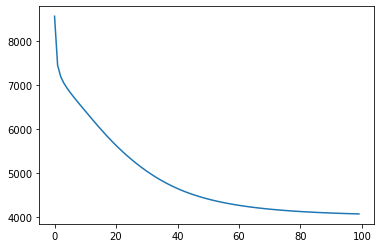

In [18]:
# Display losses over time
plt.figure()
plt.plot(losses)
plt.show()

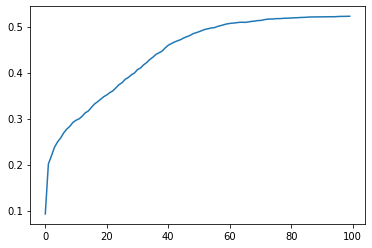

In [19]:
# Display accuracies over time
plt.figure()
plt.plot(accuracies)
plt.show()

### Questions and expected answers for the report

**A. Copy and paste your SkipGram class code (Task #1 in the notebook)**

    class SkipGram(nn.Module):
    """
    Your skipgram model here!
    """
    
    def __init__(self, context_size, embedding_dim, vocab_size):
        super(SkipGram, self).__init__()
        self.context_size = context_size
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view(1, -1)
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        out = F.log_softmax(out, dim=1)
        log_probs = torch.cat([out]*self.context_size*2) # weights are being shared
        log_probs = log_probs.view(2*self.context_size, -1)
        return log_probs

**B. Copy and paste your train function (Task #2 in the notebook), along with any helper functions you might have used (e.g. a function to compute the accuracy of your model after each iteration). Please also copy and paste the function call with the parameters you used for the train() function.**

    def get_prediction(context, model, word2index, index2word):
      """
      This is a helper function to get prediction from our model.
      """

      # Get into eval() mode
      model.eval()
      context_id = words_to_tensor([context], word2index, dtype = torch.LongTensor)

      # Forward pass
      prediction = model(context_id)

      # Return top 4 predicted words
      predicted_words = []
      ids = torch.topk(prediction, 4).indices[0]
      for index in ids:
          predicted_words.append(index2word[index.item()])

      # print("Context word: {}. Target words: {}".format(context, predicted_words))

      return predicted_words

    def check_accuracy(model, data, word2index, index2word):

      # Compute accuracy
      correct = 0
      for context, target in data:
          prediction = get_prediction(context, model, word2index, index2word)

          for word in target:
              if word in prediction:
                  correct += 1

      return correct/(4 * len(data))

    def train(data, word2index, model, epochs, loss_func, optimizer):
      losses = []
      accuracies = []

      for epoch in range(epochs):
          total_loss = 0

          for context, target in data:

              # Prepare data
              ids = words_to_tensor([context], word2index, dtype = torch.LongTensor)
              target = words_to_tensor(target, word2index, dtype = torch.LongTensor)

              # Forward pass
              model.zero_grad()
              output = model(ids)
              loss = loss_func(output, target)

              # Backward pass and optim
              loss.backward()
              optimizer.step()

              # Loss update
              total_loss += loss.data.item()

          # Display
          if epoch % 10 == 0:
              accuracy = check_accuracy(model, data, word2index, index2word)
              print("Accuracy after epoch {} is {}".format(epoch, accuracy))
              accuracies.append(accuracy)
              losses.append(total_loss)

      return losses, accuracies, model
      
      # Define training parameters
      learning_rate = 0.001
      epochs = 1000
      torch.manual_seed(28)
      loss_function = nn.NLLLoss()
      optimizer = optim.SGD(model.parameters(), lr = learning_rate)

      losses, accuracies, model = train(data, word2index, model, epochs, loss_function, optimizer)


**C. Why is the SkipGram model much more difficult to train than the CBoW. Is it problematic if it does not reach a 100% accuracy on the task it is being trained on?**

CBoW model is trained to predict a single word from a fixed window size of context words, whereas the SkipGram model does the opposite, and tries to predict several context words from a single input word. Therefore, the SkipGram model is harder to train as it needs to get high probabilities for not just 1 right output word, but the right 2k output words surrounding the input word. In our case k=2.

It is not problematic if the SkipGram model does not reach a 100% accuracy on the task it is being trained on. This is because all we want is to train a good embedding W, which can be achieved as long as the “right” surrounding context words have high probabilities --- they can appear in any order and do not necessarily need to be in the top 2k shortlisted candidates.

**D. If we were to evaluate this model by using intrinsic methods, what could be a possible approach to do so. Please submit some code that will demonstrate the performance/problems of the word embedding you have trained!**

The model does not appear to be performing very well. This is likely because our model is trained on a small corpus, so there is insufficient data to generate meaningful embeddings. For example, even though americans and citizens are used interchangeably in this racial text, and they both have syntactically similar outputs e.g. "colored" and "color" respectively, the model treats them as different words. This contributes to their low cosine similarity and poorly captures their semantic relationship. A larger text corpus is required.

In [20]:
# Manually inspect the possible outputs of the each word
print(get_prediction("americans", model, word2index, index2word))
print(get_prediction("citizens", model, word2index, index2word))
print(get_prediction("lord", model, word2index, index2word))
print(get_prediction("god", model, word2index, index2word))

['needed', 'colored', 'the', 'to']
['sweltering', 'its', 'as', 'color']
['of', 'be', 'shall', 'the']
['almighty', 'last', 'thank', 'we']


In [21]:
# Printing cosine similarity of word embeddings
word1 = words_to_tensor(["americans"], word2index, dtype=torch.LongTensor)
word2 = words_to_tensor(["citizens"], word2index, dtype=torch.LongTensor)
word3 = words_to_tensor(["lord"], word2index, dtype=torch.LongTensor)
word4 = words_to_tensor(["god"], word2index, dtype=torch.LongTensor)
w1 = torch.reshape(model.embeddings(word1), (20,))
w2 = torch.reshape(model.embeddings(word2), (20,))
w3 = torch.reshape(model.embeddings(word3), (20,))
w4 = torch.reshape(model.embeddings(word4), (20,))

cos = nn.CosineSimilarity(dim=0, eps=1e-6)
print(cos(w1,w2)) # americans, citizens
print(cos(w1,w3)) # americans, lord
print(cos(w1,w4)) # americans, god
print(cos(w2,w3)) # citizens, lord
print(cos(w2,w4)) # citizens, god
print(cos(w3,w4)) # lord, god

tensor(0.1816, device='cuda:0', grad_fn=<DivBackward0>)
tensor(0.2532, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.1035, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.2368, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.3480, device='cuda:0', grad_fn=<DivBackward0>)
tensor(-0.2210, device='cuda:0', grad_fn=<DivBackward0>)
